# Arrival Time Prediction - Synchronisation
This notebook is the third on the work on GP regression for arrival time prediction. The goal of this one is to estimate a function that synchonises the progress of all trajectories. This needs to be done so that predictions can be made based on a new trajectory and not a single data point. 

The synchonisation function will be estimated using a GP, which we are all familiar now by now. First off, let's get some libraries into scope, set the seed and load the data that was pickled in the first notebook.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats 
import math
import tensorflow as tf
from models import synch

sns.set(style="darkgrid")
np.random.seed(1)
df = pd.read_pickle('train.pkl')

## Exploring the data
Let's look at just one trajectory and plot the coordinates

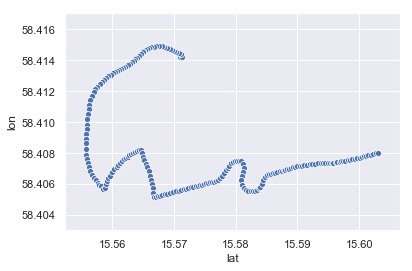

In [2]:
traj_df = df[df.traj == 1]
sns.scatterplot(x="lat", y="lon", data=traj_df)

It looks nice! We can also visualise the segments and their time remaining to next bus stop, where we can see that the behaviour is a bit peaky. This is beacuse data points are filtered out since they are too close in the pre processing step.

C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


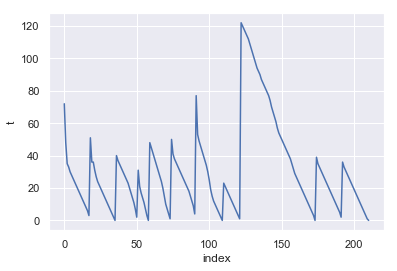

In [3]:
# All segments
traj_df['index'] = traj_df.index
sns.lineplot(data=traj_df, x='index', y='t')

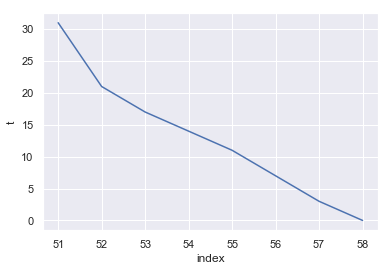

In [4]:
# single segment
sns.lineplot(data=traj_df[traj_df.seg == 4], x='index', y='t')

Since the segments are very different we will train a separate GP for each segment. Let's start out easy and learn a synchronisation function for a nice segment, but first lets plot it.

Segment spatially

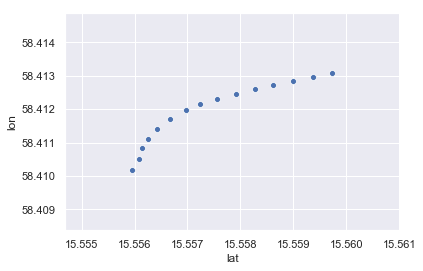

In [5]:
seg = traj_df[traj_df.seg == 3]
sns.scatterplot(x="lat", y="lon", data=seg)

Segment time until arrival

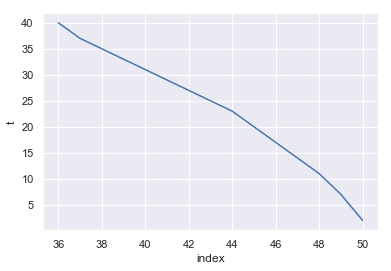

In [6]:
sns.lineplot(data=seg, x='index', y='t')

Segment spatially scaled to zero mean and unit variance

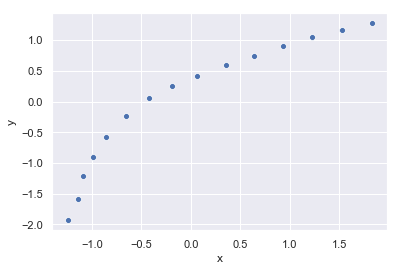

In [10]:
X_unnorm = np.vstack((seg['lat'], seg['lon'])).T 
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)

norm_traj= pd.DataFrame(X, columns = list('xy'))
sns.scatterplot(x='x', y='y', data=norm_traj)

## Hyperparameter Priors
NOTE: The text in this chapter may very well be out of synch with the results from the code, depending on which segement that the model is being trained on and me switching around the priors. I have a tendency of changing it around to see how results look on different trajectories.


The synchronisation function is a function f : R^2 -> [0, 1] so we will use a bivariate GP model. Let's look at some priors for the hyperparameters kernel lengthscale, kernel variance and likelihood variance. 

### Kernel Lenghtscale
First off, lets look at two nearby points

0.00036907196040303347
9.918212890625e-05


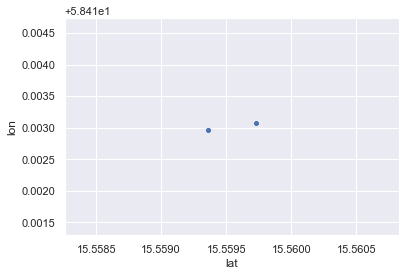

In [9]:
first_two_points = seg.iloc[0:2]
sns.scatterplot(x='lat', y='lon', data=first_two_points)
delta_lat = first_two_points.iloc[0].lat - first_two_points.iloc[1].lat
delta_lon = first_two_points.iloc[0].lon - first_two_points.iloc[1].lon
print(delta_lat)
print(delta_lon)

Since GPFlow is quite a minimalistic library (that is: a bit buggy, and poorly documented), there is no way of plotting kernel functions, and the function to compute covariance matrices at all, `k.compute_K`, seem to be busted beyond belief. Plotting will have to be done by implementing the function by oneself and using it for plotting. Thus you find an implementation of the RBF kernel function below. 

Since the difference of the points were 9.500000000173259e-05 which is about 0.0001 we want the kernel function to give a high value here, since they should be highly correlated. Plotting it for some different parameters show that sigma = 0.0002 gives something close to what we want.

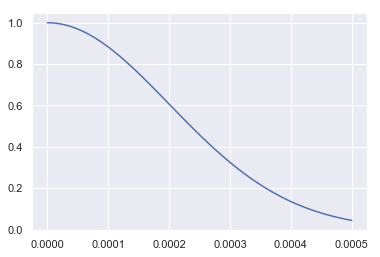

In [7]:
def rbf(X, x, var, sigma):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(sigma, 2)))

xmin = 0
xmax = 0.0005
xx = np.linspace(xmin, xmax, 100)[:,None]
#np.exp((xx-1)*(xx-1))
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.0002)[:,0])

We put a fairly certain prior on the kernel sigma arount 0.0002 based on our previous investigations. This is really just a guess based on two observations but it gives some direction on how one could go about selecting a prior.

After trying this out it was apparent that the sigma was way to small, and that the model did not generalise. Some experiments with different lengthscale priors have been made, check the code for the current values.

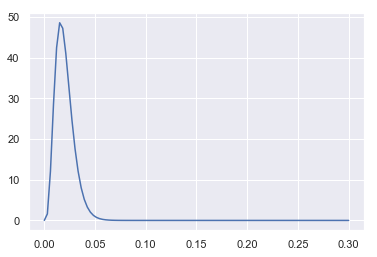

In [8]:
xmin = 0
xmax = 0.3
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=5, scale=0.004)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Kernel Variance
todo

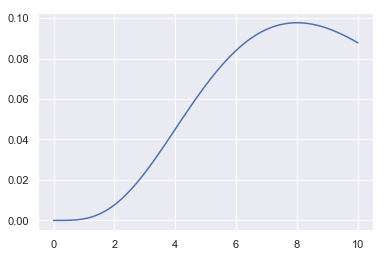

In [11]:
xmin = 0
xmax = 10
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=5, scale=2)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Likelihood Variance
We also need to chose a prior for the likelihood variance, that is, the measurement noise. This model will assume a static variance, even though we know that it depends on where in the city you are. In mode dense areas the GPS accuracy suffers a bit while it works well in more rural areas. A seperate model for the GPS variance estimation should be used if this was done properly.

Looking back at the two data points that we now consider different, the noise should probably be smaller than that distance. If we assume that the measurement noise is around 0.00005, which is half the distance between the two points a suitable prior is the following gamma distribution

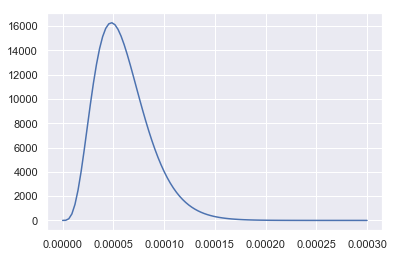

In [12]:
xmin = 0
xmax = 0.0003
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=5, scale=0.000012)
sns.lineplot(x = xx[:,0], y = y[:,0])

## Training
Alrighty, time to train a GP. The idea here is to train on a single trajectory that embodies what we want from the synchronisation and then evaluate that on other trajectories. A property that we want from the estimated function is for it to be a smooth mapping with respect to spatial progress, that is, we want regions that are close progressionwise in the domain to be close in the codomain. This is not something a GP guarantees at all, so to force it to learn something closer to what we want the data is duplicated with a small offset, as can be seen in the figure below.

The code uses the singular value decomposition to compute the eigenvectors of the data, and offset the copies in the direction of the smaller of the two. This approach assumes a nice trajectory with a large first eigenvalue and small second, which will not be the case for all routes, but will probably work well in rural areas where ther aren't many turns.

In [13]:
n_train = 1
seg_n = 3
train_traj = df[df.traj == n_train]
train_seg = train_traj[train_traj.seg == seg_n]

#segs = train[train.seg == seg_n]
#test = test[1:len(test)] # First data point has t = 0.0 which is not what the model expects
#train = train[1:len(train)] # First data point has t = 0.0 which is not what the model expects

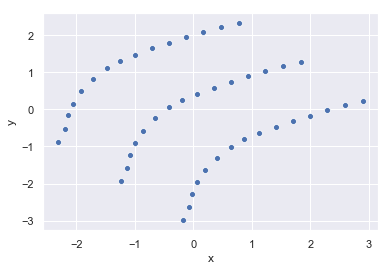

In [14]:
X_unnorm = np.vstack((train_seg['lat'], train_seg['lon'])).T
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)
u, s, vh = np.linalg.svd(X)
v1 = 1.5*vh[1,:]
norm_traj= pd.DataFrame(np.vstack((X, X+v1, X-v1)), columns = list('xy'))
sns.scatterplot(x='x', y='y', data=norm_traj)

The duplicated data has the same labels, so the function will only change in the direction of the spatial progression, which is exactly what we want.  

In [ ]:
X = np.vstack((train_seg['lat'], train_seg['lon'])).T   
Y = 1 - np.array(train_seg['t']).reshape(train_seg.shape[0],1) / train_seg['t'].max() # Temporal progress
m, X, Y = synch.train(X_unnorm, Y, duplicate_data = True, use_priors = False)

Lets plot the fits mean vs progress. These should be linear if the function maps correctly

In [ ]:
mean, var = m.predict_y(X)
progress_df = pd.DataFrame(np.hstack([X,Y,mean]), columns=list('xypm'))
sns.lineplot(x ='p', y='m', data=progress_df)
m.as_pandas_table()

In [ ]:
def plot_posterior(model, X, seg): 
    padding = 0 # Padding does not work when overlaying the data in scatterplot (different scales)
    norm_latmax = X[:,0].max() + padding
    norm_latmin = X[:,0].min() - padding 
    norm_longmax = X[:,1].min() - padding
    norm_longmin = X[:,1].max() + padding
    d = 200

    # Prediction mesh
    xlist = np.linspace(norm_latmin, norm_latmax, d)
    ylist = np.linspace(norm_longmin, norm_longmax, d)
    xx, yy = np.meshgrid(xlist, ylist)
    grid = np.array([np.reshape(xx,(-1,)).T,np.reshape(yy,(-1,))]).T
    mean, var = model.predict_y(grid)
    hm_grid = mean.reshape(d,d)[::-1] # Reshape to correct dim and flip in y direction
    hm = sns.heatmap(hm_grid, vmin= 0, vmax=1, cmap="YlGnBu")
    hm.invert_yaxis() # Invert Y-axis to get same orientation as the data

    # Overlay data scatterplot
    lat_unnorm = seg['lat']
    lon_unnorm = seg['lon']

    # Map data onto heatmap integer space. Worthless, but had no luck in doing the inverse
    lat_grid = ((lat_unnorm-lat_unnorm.min()) / 
                    (lat_unnorm.max() - lat_unnorm.min()))*d
    lon_grid = ((lon_unnorm-lon_unnorm.min()) / 
                    (lon_unnorm.max() - lon_unnorm.min()))*d
    df_grid = pd.DataFrame({'lat':lat_grid, 'lon': lon_grid})
    sns.scatterplot(x='lat', y='lon', data=df_grid, color=".2", axes=hm)

plot_posterior(m, X, train_seg)

As can bee seen from the two previous plots, the function seem to capture the progression of the training data very well. The question is, will it generalise?

In [15]:
n_test = 20
test_traj = df[df.traj <= n_test]
test_seg = test_traj[test_traj.seg == seg_n]
plot_posterior(m, X, test_seg)

NameError: name 'plot_posterior' is not defined

This plot looks very promising indeed! For this very nice segement the synchonisation seem to have been successful. Let's try the same approach on a harder one.

In [ ]:
hard_seg = traj_df[traj_df.seg == 9]
sns.scatterplot(x="lat", y="lon", data=hard_seg)

Trying to duplicate the data with an offset in the direction of the smallest eigenvalue is shown to be a terrible strategy for this segment as can be seen below, so let's just train on the original segment for now.

In [ ]:
X_unnorm = np.vstack((hard_seg['lat'], hard_seg['lon'])).T
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)
u, s, vh = np.linalg.svd(X)
v1 = 1.5*vh[1,:]
norm_traj= pd.DataFrame(np.vstack((X, X+v1, X-v1)), columns = list('xy'))
sns.scatterplot(x='x', y='y', data=norm_traj)

In [ ]:
X = np.vstack((hard_seg['lat'], hard_seg['lon'])).T
Y = 1 - np.array(hard_seg['t']).reshape(hard_seg.shape[0],1) / train_seg['t'].max() # Temporal progress
m, X, Y = synch.train(X, Y, duplicate_data = False, use_priors = False)
plot_posterior(m, X, hard_seg)

In [ ]:
mean, var = m.predict_y(X)
progress_df = pd.DataFrame(np.hstack([X,Y,mean]), columns=list('xypm'))
sns.lineplot(x ='p', y='m', data=progress_df)
m.as_pandas_table()

Somewhat expected, this model does not work on more complicated segments, but it can be used to make predictions on simpler ones for now so let's save it and proceed with the prediction step of the model in the next notebook.

In [ ]:
from models import synch
synch.save('synch.pkl', m)